In [2]:
from keras.datasets import mnist
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping

def balanced_mnist_set():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalizar los datos
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Balancear los datos
    idx_y_train_5 = np.where(y_train == 5)[0]
    idx_y_train_n5 = np.where(y_train != 5)[0]
    idx_y_train_n5 = np.random.choice(idx_y_train_n5, idx_y_train_5.shape[0], replace=False)

    idx_y_train = np.concatenate([idx_y_train_5, idx_y_train_n5])
    np.random.shuffle(idx_y_train)

    x_train = x_train[idx_y_train]
    y_train = y_train[idx_y_train]

    idx_y_test_5 = np.where(y_test == 5)[0]
    idx_y_test_n5 = np.where(y_test != 5)[0]
    idx_y_test_n5 = np.random.choice(idx_y_test_n5, idx_y_test_5.shape[0], replace=False)

    idx_y_test = np.concatenate([idx_y_test_5, idx_y_test_n5])
    np.random.shuffle(idx_y_test)

    x_test = x_test[idx_y_test]
    y_test = y_test[idx_y_test]

    y_train_binary = (y_train == 5).astype(int)
    y_test_binary = (y_test == 5).astype(int)

    return (x_train, y_train_binary), (x_test, y_test_binary)

# Cargar y balancear los datos
(x_train, y_train_binary), (x_test, y_test_binary) = balanced_mnist_set()

# Definir el modelo
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train_binary, epochs=20, batch_size=128,
                    validation_split=0.2, callbacks=[early_stopping])


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/20
68/68 [==============================] - 1s 6ms/step - loss: 0.5045 - accuracy: 0.7828 - val_loss: 0.3734 - val_accuracy: 0.8760
Epoch 2/20
68/68 [==============================] - 0s 4ms/step - loss: 0.3193 - accuracy: 0.8902 - val_loss: 0.2890 - val_accuracy: 0.9096
Epoch 3/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.9073 - val_loss: 0.2539 - val_accuracy: 0.9129
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2373 - accuracy: 0.9158 - val_loss: 0.2357 - val_accuracy: 0.9133
Epoch 5/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9196 - val_loss: 0.2248 - val_accuracy: 0.9147
Epoch 6/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2104 - accuracy: 0.9224 - val_loss: 0.2137 - val_accuracy: 0.9225
Epoch 7/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2020 - accuracy: 0.92

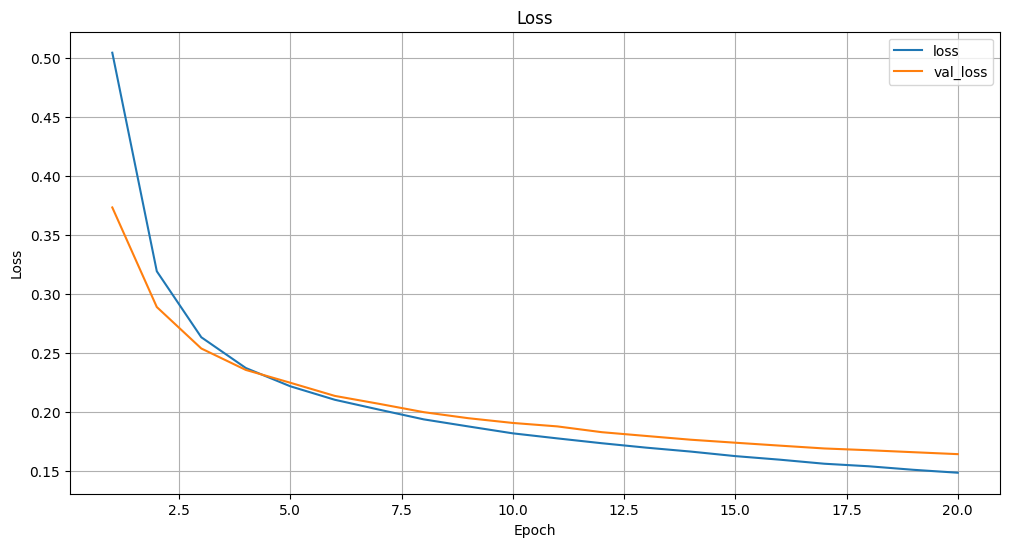

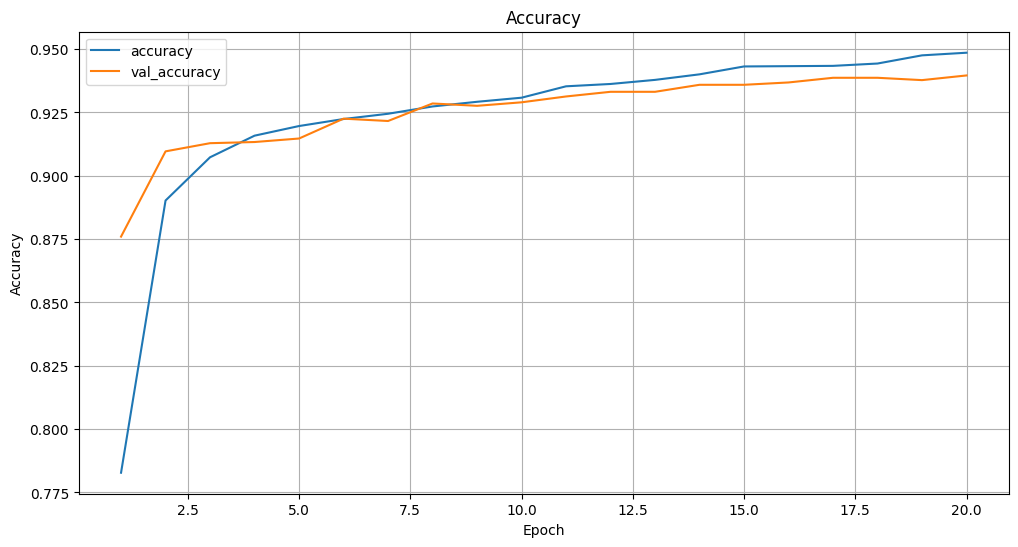

56/56 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       892
           1       0.96      0.93      0.94       892

    accuracy                           0.94      1784
   macro avg       0.94      0.94      0.94      1784
weighted avg       0.94      0.94      0.94      1784

Confusion Matrix:
[[854  38]
 [ 66 826]]


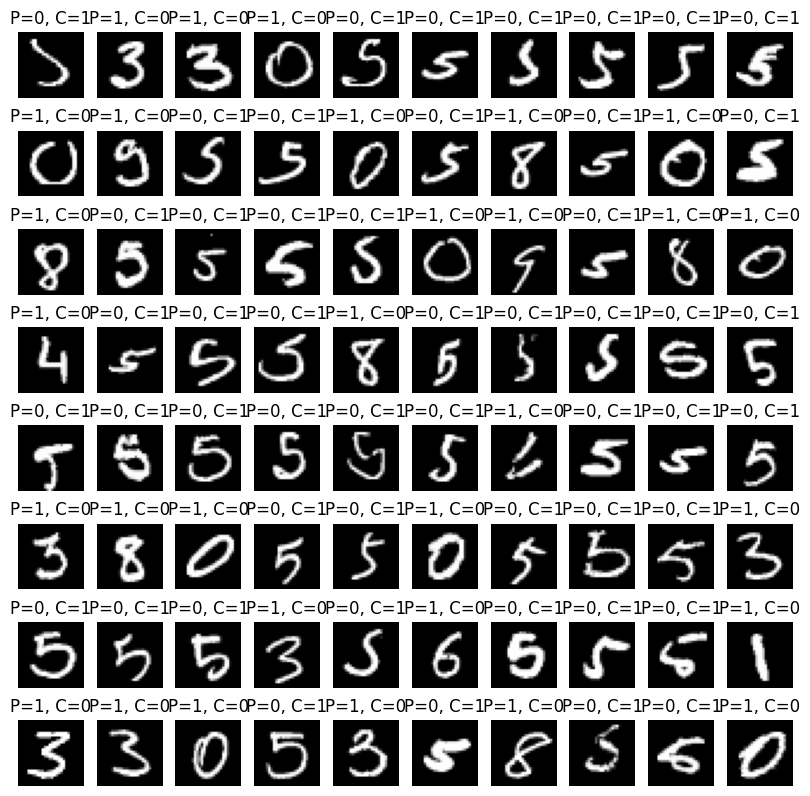

In [3]:
import matplotlib.pyplot as plt

# Historia de entrenamiento
loss_train = history.history['loss']
loss_val = history.history['val_loss']
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1, len(loss_train) + 1)

# Graficar Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_train, label='loss')
plt.plot(epochs, loss_val, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Graficar Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_train, label='accuracy')
plt.plot(epochs, accuracy_val, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluación del modelo
y_pred = (model.predict(x_test) >= 0.5).astype(int).flatten()

# Métricas
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test_binary, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred))

# Mostrar imágenes de errores
incorrect_indices = np.where(y_pred != y_test_binary)[0]
incorrect_samples = x_test[incorrect_indices][:80]

plt.figure(figsize=(10, 10))
for i in range(len(incorrect_samples)):
    plt.subplot(8, 10, i + 1)
    plt.imshow(incorrect_samples[i], cmap='gray')
    plt.title("P={}, C={}".format(y_pred[incorrect_indices[i]], y_test_binary[incorrect_indices[i]]))
    plt.axis('off')
plt.show()


56/56 [==============================] - 0s 4ms/step


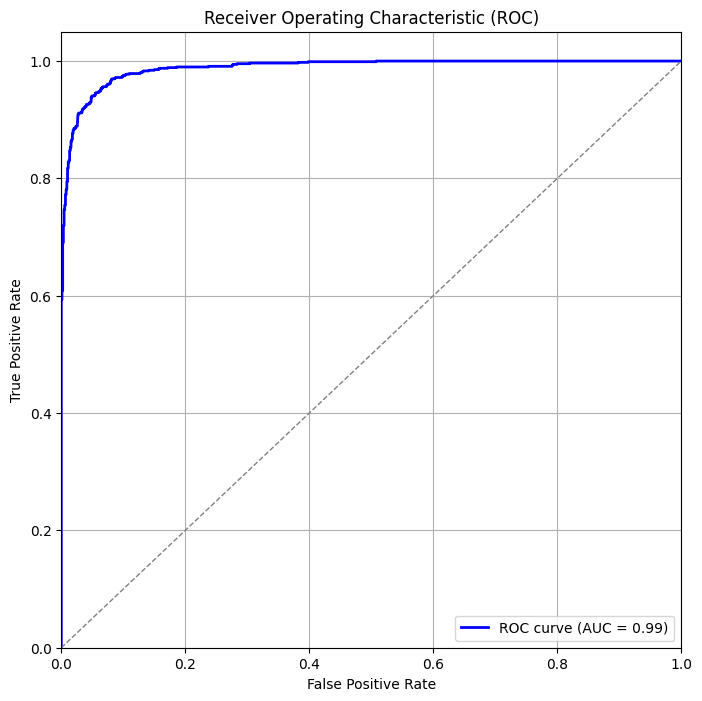

Area sobre la Curva: 0.9882261859277284
Umbral óptimo: 0.425297


In [8]:
from sklearn.metrics import roc_curve, auc

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(x_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Encontrar el umbral óptimo
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Area sobre la Curva:", roc_auc)
print("Umbral óptimo:", optimal_threshold)


El área sobre la curva ROC (AUC) es una medida de la capacidad de discriminación del modelo. Indica la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor de AUC cercano a 1 indica un modelo muy bueno, mientras que un valor cercano a 0.5 indica un modelo que no es mejor que un clasificador aleatorio.

En este caso el valor del umbral obtenido fue de 0.425297,este fue ya que a mi consideracion es el umbral que proporciona el mejor equilibrio entre la sensibilidad y la especificidad en el conjunto de datos de prueba.